In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

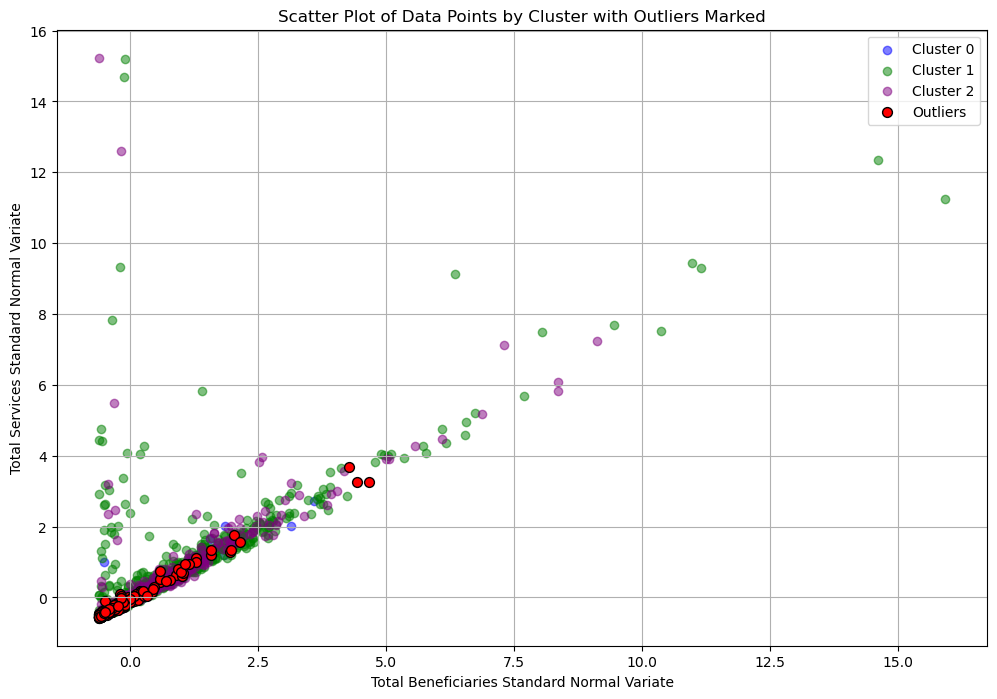

   Tot_Benes  Tot_Srvcs  Avg_Mdcr_Stdzd_Amt  \
0         28       32.0              581.89   
1         29       38.0              771.93   
2         11       12.0              562.18   
3         13       22.0              117.75   
4         12       16.0              588.58   

   Tot_Benes_standard_normal_variate  Tot_Srvcs_standard_normal_variate  \
0                           0.171025                          -0.005644   
1                          -0.536889                          -0.502801   
2                          -0.451940                          -0.417084   
3                           0.907255                           0.628660   
4                          -0.565206                          -0.537088   

   Avg_Mdcr_Stdzd_Amt_standard_normal_variate  Is_Outlier  Cluster  \
0                                    1.455960       False        1   
1                                   -0.326763       False        2   
2                                   -0.155901       Fals

In [2]:
# Load the data
data = pd.read_csv('original_data.csv')

# Define a function to calculate outliers based on the IQR
def calculate_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data[column] < lower_bound) | (data[column] > upper_bound)

# Select features for clustering
X = data[['Tot_Benes_standard_normal_variate', 'Tot_Srvcs_standard_normal_variate', 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate']]

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

# Calculate distances from each point to its cluster center
distances = np.sqrt(((X - centroids[labels]) ** 2).sum(axis=1))
threshold = np.percentile(distances, 95)
data['Is_Outlier'] = distances > threshold
data['Cluster'] = labels  # Add cluster labels to the dataframe

# Apply IQR method to each column
data['IQR_Outlier_Tot_Benes'] = calculate_outliers_iqr(data, 'Tot_Benes_standard_normal_variate')
data['IQR_Outlier_Tot_Srvcs'] = calculate_outliers_iqr(data, 'Tot_Srvcs_standard_normal_variate')
data['IQR_Outlier_Avg_Mdcr_Amt'] = calculate_outliers_iqr(data, 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate')

# Combine the three IQR outlier columns into a single 'Actual_Outliers' column
data['Actual_Outliers'] = data[['IQR_Outlier_Tot_Benes', 'IQR_Outlier_Tot_Srvcs', 'IQR_Outlier_Avg_Mdcr_Amt']].any(axis=1)

# Function to reverse the trend of a segment of data for specified columns
def reverse_trend(data, columns, start_index, end_index,fraction=0.05):
    poisoned_data = data.copy()
    for col in columns:
        poisoned_data.loc[start_index:end_index, col] = poisoned_data.loc[start_index:end_index, col].iloc[::-1].values
    return poisoned_data

# Specify the columns and segment to reverse the trend in
columns_to_convert = ['Tot_Benes_standard_normal_variate', 'Tot_Srvcs_standard_normal_variate', 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate']
start_index = 0  # Starting index of the segment
end_index = 3977    # Ending index of the segment
trend_reversed_data = reverse_trend(data, columns_to_convert, start_index, end_index)

# Plotting
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'purple']

for cluster in range(3):
    cluster_data = trend_reversed_data[trend_reversed_data['Cluster'] == cluster]
    plt.scatter(cluster_data['Tot_Benes_standard_normal_variate'], cluster_data['Tot_Srvcs_standard_normal_variate'], color=colors[cluster], label=f'Cluster {cluster}', alpha=0.5)

outliers = trend_reversed_data[trend_reversed_data['Is_Outlier']]
plt.scatter(outliers['Tot_Benes_standard_normal_variate'], outliers['Tot_Srvcs_standard_normal_variate'], color='red', label='Outliers', edgecolor='k', s=50)

plt.title('Scatter Plot of Data Points by Cluster with Outliers Marked')
plt.xlabel('Total Beneficiaries Standard Normal Variate')
plt.ylabel('Total Services Standard Normal Variate')
plt.legend()
plt.grid(True)
plt.show()

# Print the head of the dataset with the trend reversed
print(trend_reversed_data.head())
trend_reversed_data.to_csv('trend_data_outliers_0.05_with_s_2000_&_3000.csv', index=False)


Confusion Matrix:
[[3482    0]
 [ 295  199]]


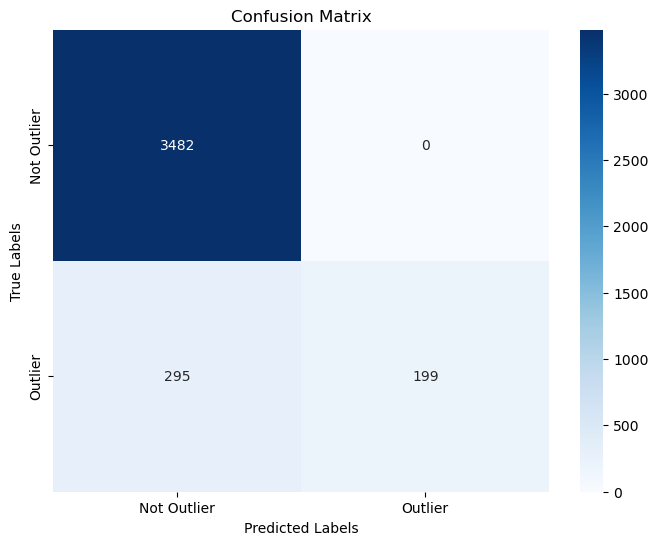

In [3]:
data = pd.read_csv('trend_data_outliers_0.05_with_s_2000_&_3000.csv')

# Extract actual and predicted labels
actual_labels = data['Actual_Outliers']
predicted_labels = data['Is_Outlier']

# Calculate the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Outlier', 'Outlier'], yticklabels=['Not Outlier', 'Outlier'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [4]:
# Define the condition for each classification
conditions = [
    (actual_labels == False) & (predicted_labels == False),  # True Negative
    (actual_labels == False) & (predicted_labels == True),   # False Positive
    (actual_labels == True) & (predicted_labels == False),   # False Negative
    (actual_labels == True) & (predicted_labels == True)     # True Positive
]

# Define the label for each condition
labels = ['TN', 'FP', 'FN', 'TP']

# Create a new column in the dataframe that describes the classification of each data point
data['Classification'] = pd.Series(np.select(conditions, labels, default='Error'))

# Count the occurrences of each classification
classification_counts = data['Classification'].value_counts()

# Create a DataFrame for the counts
counts_df = pd.DataFrame(classification_counts).reset_index()
counts_df.columns = ['Classification', 'Count']

# Optionally print out the counts
print(counts_df)

# Save the modified data with the new classification to CSV
data.to_csv('modified_noise_data_with_classifications.csv', index=False)

# Save the counts to the same or a different CSV file
counts_df.to_csv('classification_counts.csv', index=False)

# Optionally, print out a few rows to see the classifications
print(data[['Actual_Outliers', 'Is_Outlier', 'Classification']].head())


  Classification  Count
0             TN   3482
1             FN    295
2             TP    199
   Actual_Outliers  Is_Outlier Classification
0            False       False             TN
1            False       False             TN
2            False       False             TN
3             True        True             TP
4            False       False             TN
